# Azure AI Foundry Agent Service - Code Interpreterを使ったシングルエージェント

## 概要

このハンズオンでは、Azure AI Foundry Agent ServiceのCode Interpreter機能を使用して、データ分析や計算、グラフ作成を行うAIエージェントを作成します。

### 学習内容
- エージェントによる自動的なPythonコード生成と実行
- データ分析とグラフ可視化を行うエージェントの作成

# ライブラリのインポート

必要なPythonライブラリとAzure AI Foundry SDKをインポートします。

In [14]:
import os
import json
import datetime
import zoneinfo

import requests

from dotenv import load_dotenv, find_dotenv

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    ListSortOrder,
    CodeInterpreterTool,
    FunctionTool,
    ToolSet,
)
from IPython.display import Image, display

# 環境変数の取得

Azure AI Foundryへの接続に必要な設定情報を環境変数から取得します。

- `PROJECT_ENDPOINT`: Azure AI Foundryプロジェクトのエンドポイント
- `AZURE_DEPLOYMENT_NAME`: 使用するAIモデルのデプロイメント名

これらの値は事前に.envファイルに設定されている必要があります。

In [15]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")

# クライアントの初期化

Azure AI Foundryプロジェクトへの接続とエージェント管理用のクライアントを初期化します。

- `AIProjectClient`: Azure AI Foundryプロジェクトとの接続を管理
- `DefaultAzureCredential`: Azure認証（Azure CLI、Managed Identity等を自動検出）
- `agents_client`: エージェントの作成・管理・実行を行うクライアント

In [16]:
# AI Project Client を初期化
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# AgentClient の作成
agents_client = project_client.agents

# ユーティリティ関数

エージェントの実行結果を表示するためのヘルパー関数を定義します。

`agent_run_outputs`関数は以下の機能を提供します：
- スレッド内のメッセージ一覧を取得・表示
- 画像コンテンツがある場合は保存・表示
- ツール呼び出し情報の詳細表示（Run Stepsから取得）

In [17]:
def agent_run_outputs(thread_id, agents_client, target_dir="./output_images", show_tool_calls=True, run_id=None):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像・ツール呼び出し）をNotebook上に表示＆画像は保存。
    
    Args:
        thread_id: スレッドID
        agents_client: エージェントクライアント
        target_dir: 画像保存ディレクトリ
        show_tool_calls: ツール呼び出し情報を表示するかどうか
        run_id: 特定のRunのツール呼び出し情報を表示する場合のRun ID
    """
    from IPython.display import Image, display
    from azure.ai.agents.models import RunStepToolCallDetails, RunStepFunctionToolCall, RunStepMessageCreationDetails
    
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    # メッセージの重複防止
    displayed_message_ids = set()
    
    # メッセージの表示
    for message in messages:
        # メッセージの重複チェック
        if message.id in displayed_message_ids:
            continue
        displayed_message_ids.add(message.id)
        
        print(f"\n{'='*60}")
        print(f"MESSAGE ROLE: {message.role.upper()}")
        print(f"MESSAGE ID: {message.id}")
        print(f"{'='*60}")
        
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{txt.text.value}")
        
        # 画像出力
        if hasattr(message, "image_contents") and message.image_contents:
            print(f"\n[IMAGES]")
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"  Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))
    
    # ツール呼び出し情報の表示（Run Stepsから取得）
    if show_tool_calls and run_id:
        print(f"\n{'='*60}")
        print(f"RUN STEPS INFORMATION (RUN ID: {run_id})")
        print(f"{'='*60}")
        
        try:
            # Run Stepsを取得（デフォルトは新しい順なので、古い順に並び替え）
            run_steps = agents_client.run_steps.list(thread_id=thread_id, run_id=run_id)
            run_steps_list = list(run_steps)
            run_steps_list.reverse()  # 実行順序に並び替え（STEP1から順番に）
            
            # 重複防止のためのセット
            displayed_step_ids = set()
            
            print(f"Total Run Steps: {len(run_steps_list)}")
            
            # 全てのrun stepsを実行順序で表示
            for step_num, run_step in enumerate(run_steps_list, 1):
                # 重複チェック
                if run_step.id in displayed_step_ids:
                    print(f"[STEP {step_num}] - SKIPPED (Duplicate Step ID: {run_step.id})")
                    continue
                displayed_step_ids.add(run_step.id)
                
                print(f"\n[STEP {step_num}] - {run_step.type}")
                print(f"  Step ID: {run_step.id}")
                print(f"  Status: {run_step.status}")
                
                # Message Creation Step
                if isinstance(run_step.step_details, RunStepMessageCreationDetails):
                    print(f"  Message Creation Step")
                    if hasattr(run_step.step_details.message_creation, 'message_id'):
                        print(f"  Message ID: {run_step.step_details.message_creation.message_id}")
                
                # Tool Calls Step
                elif isinstance(run_step.step_details, RunStepToolCallDetails):
                    print(f"  Tool Calls Step - {len(run_step.step_details.tool_calls)} tool(s)")
                    
                    for tool_num, tool_call in enumerate(run_step.step_details.tool_calls, 1):
                        print(f"\n    [TOOL CALL {tool_num}]")
                        print(f"    Tool Type: {tool_call.type}")
                        print(f"    Tool Call ID: {tool_call.id}")
                        
                        # Function Tool Call の詳細
                        if isinstance(tool_call, RunStepFunctionToolCall):
                            print(f"    Function Name: {tool_call.function.name}")
                            print(f"    Function Arguments: {tool_call.function.arguments}")
                            # 関数の実行結果を表示（利用可能な場合）
                            if hasattr(tool_call.function, 'output') and tool_call.function.output:
                                print(f"    Function Output: {tool_call.function.output}")
                            elif hasattr(tool_call.function, 'outputs') and tool_call.function.outputs:
                                print(f"    Function Outputs: {tool_call.function.outputs}")
                            elif hasattr(tool_call.function, 'result') and tool_call.function.result:
                                print(f"    Function Result: {tool_call.function.result}")
                        
                        print(f"    {'-'*30}")
                
                # その他のステップタイプ
                else:
                    print(f"  Step Type: {type(run_step.step_details).__name__}")
                
                print(f"  Created At: {run_step.created_at}")
                if hasattr(run_step, 'completed_at') and run_step.completed_at:
                    print(f"  Completed At: {run_step.completed_at}")
                
                print(f"  {'='*50}")
                
        except Exception as e:
            print(f"Error retrieving run steps: {e}")
            print(f"Run ID: {run_id}, Thread ID: {thread_id}")

# ツールの定義

エージェントが使用できるツールを定義します。このノートブックでは2種類のツールを使用します。

## 使用するツール
1. **Code Interpreter**: Pythonコードの自動生成・実行、データ分析、グラフ作成
2. **カスタム関数**: 外部APIからのデータ取得（気温情報等）

これらのツールを組み合わせることで、データ取得から分析・可視化まで一連の処理を自動化できます。

## Code Interpreter

Code Interpreterは、エージェントがPythonコードを自動生成・実行する機能です。

### Code Interpreterの機能
- **データ分析**: pandas、numpyを使った統計処理
- **可視化**: matplotlib、seabornでのグラフ作成
- **計算処理**: 数学的計算や数値処理
- **ファイル操作**: CSV読み込み、画像保存等

エージェントは自然言語の要求を理解し、適切なPythonコードを生成して実行します。

In [18]:
# Code Interpreter ツールの定義
codeinterpreter = CodeInterpreterTool()

## カスタム関数

01のノートブックと同じカスタム関数を定義します。これらの関数でデータを取得し、Code Interpreterで分析・可視化を行います。

### 定義する関数
1. **get_prefecture_location**: 都道府県名から緯度・経度を取得
2. **get_current_time_jst**: 日本標準時の現在日付を取得
3. **get_temperature**: 指定座標・日付の気温を外部APIから取得

Code Interpreterと組み合わせることで、「データ取得 → 分析 → 可視化」の一連の流れを自動化できます。

In [19]:
def get_prefecture_location(prefecture: str) -> str:
    """
    都道府県名から緯度・経度を取得します。都道府県一覧・座標は変更しません。

    :param prefecture (str): 都道府県名（例: "東京都"）
    :rtype: str

    :return: {"latitude": ..., "longitude": ...} 形式のJSON文字列。見つからなければ {"latitude": null, "longitude": null}
    :rtype: str
    """
    json_path ="../../infra/sample_data/prefecture_locations.json"
    with open(json_path, "r", encoding="utf-8") as f:
        PREFECTURE_LOCATIONS = json.load(f)
        
    loc = PREFECTURE_LOCATIONS.get(prefecture)
    if loc:
        return json.dumps({"latitude": loc[0], "longitude": loc[1]})
    else:
        return json.dumps({"latitude": None, "longitude": None})


def get_current_time_jst() -> str:
    """
    日本標準時（JST, UTC+9）の今日の日付を "YYYY-MM-DD" 形式の文字列で返します。日時情報は変更しません。

    :rtype: str

    :return: 今日の日付（"YYYY-MM-DD" 形式の文字列）
    :rtype: str
    """
    jst = zoneinfo.ZoneInfo("Asia/Tokyo")
    now = datetime.datetime.now(jst)
    return now.strftime("%Y-%m-%d")


def get_temperature(latitude: float, longitude: float, date: str) -> str:
    """
    指定した緯度・経度と日付に基づき、Open-Meteo APIで該当日の平均気温（摂氏）を返します。
    外部サービスのみ参照し、情報は変更しません。

    :param latitude (float): 緯度
    :param longitude (float): 経度
    :param date (str): 日付（"YYYY-MM-DD" 形式）
    :rtype: str

    :return: 指定日の平均気温（摂氏）をJSON文字列で返します。データがなければ {"temperature": null}。
    :rtype: str
    """
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={latitude}&longitude={longitude}"
        f"&start_date={date}&end_date={date}"
        "&daily=temperature_2m_mean"
        "&timezone=Asia%2FTokyo"
    )
    resp = requests.get(url, timeout=5)
    resp.raise_for_status()
    data = resp.json()
    temps = data.get("daily", {}).get("temperature_2m_mean", [])
    value = temps[0] if temps else None
    return json.dumps({"temperature": value})


## Toolset に格納

定義したツール（Code InterpreterとカスタムFunction）をエージェントが使用できる形式（ToolSet）に格納します。

### ツールセットの構成
- `CodeInterpreterTool`: Python実行環境とデータ分析・可視化機能
- `FunctionTool`: 外部APIとの連携機能
- `enable_auto_function_calls`: 自動関数呼び出し設定

この設定により、エージェントは必要に応じてデータを取得し、それをCode Interpreterで分析・可視化できるようになります。

In [20]:
# Toolset の作成＆関数の追加
toolset = ToolSet()

# Code Interpreter ツールを追加
toolset.add(codeinterpreter)

# カスタム関数ツールの定義
functions = FunctionTool(functions={get_prefecture_location, get_current_time_jst, get_temperature})
toolset.add(functions)

# エージェントで関数を自動的に呼び出すように設定
agents_client.enable_auto_function_calls(functions)

# エージェントの作成

Foundry エージェントを作成します。

In [21]:
code_interpreter_agent = agents_client.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたは日本国内の気温や地理情報に答えたり、計算や図表の出力に特化したアシスタントです。"
        "利用可能なツールを確認し、必要に応じて使用してください。"    
        "なお、グラフを描画する際は日本語が文字化けするため、ラベルやタイトルは英語で出力してください。"    
    ),
    description=(
        "Code Interpreter を利用して、計算や図表の出力に特化した分析アシスタントです。"
    ),
    tools=toolset.definitions,
)
print(f"Created Agent. AGENT_ID: {code_interpreter_agent.id}")


Created Agent. AGENT_ID: asst_MnnislspLtYlyeM7OdHtavy4


# スレッドの作成

エージェントとの対話を管理するスレッドを作成します。

In [22]:
# Thread の作成
thread = agents_client.threads.create()
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: thread_ucAf37rZkOWyp3IMx3sDVkCm


# ユーザーメッセージの追加

スレッドにユーザーからの質問やリクエストを追加します。

In [23]:
user_message_01= (
    "過去5日間の東京都、沖縄県の平均気温を調べてください。"
    "また、それをグラフで出力してください。"
)

message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_01,
)

print(f"Added Message. MESSAGE_ID: {message.id}")

Added Message. MESSAGE_ID: msg_aGXNLLmmHZP8ZgJv7wiwXIm6


# Run の実行

エージェントにタスクを実行させ、結果を取得します。


MESSAGE ROLE: USER
MESSAGE ID: msg_aGXNLLmmHZP8ZgJv7wiwXIm6
過去5日間の東京都、沖縄県の平均気温を調べてください。また、それをグラフで出力してください。

MESSAGE ROLE: ASSISTANT
MESSAGE ID: msg_BOFWMoaOZspsQ6uS6GXSaPaw
上のグラフは、過去5日間の東京都と沖縄県の平均気温を示しています。日ごとの変化や両県の気温差を比較できます。数値を下にまとめます。

【東京都の平均気温（過去5日間）】
- 7/26: 28.8℃
- 7/27: 28.5℃
- 7/28: 28.0℃
- 7/29: 28.0℃
- 7/30: 27.2℃

【沖縄県の平均気温（過去5日間）】
- 7/26: 28.5℃
- 7/27: 28.2℃
- 7/28: 28.0℃
- 7/29: 28.5℃
- 7/30: 28.6℃

ご希望があればその他の期間や都道府県の比較も可能です。

[IMAGES]
  Saved image: assistant-MKcMsAZjUnosnVqsSdPfJs_image_file.png


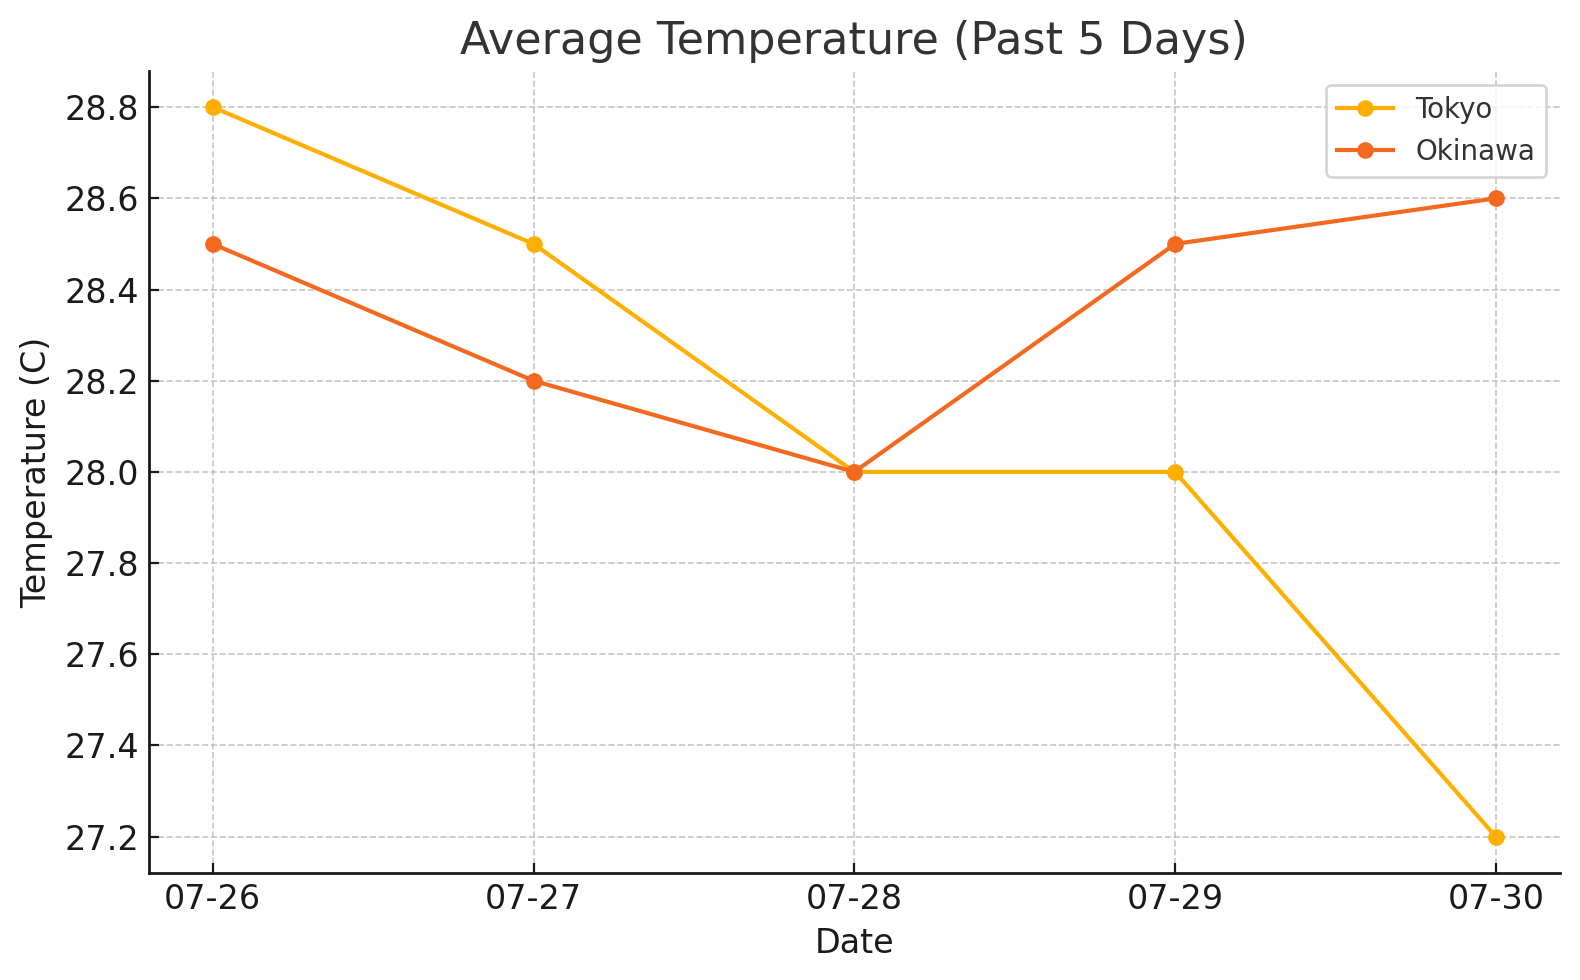


RUN STEPS INFORMATION (RUN ID: run_4nUi89NHsyI0FRN88qw9aUTF)
Total Run Steps: 4

[STEP 1] - RunStepType.TOOL_CALLS
  Step ID: step_QZWYqSdJwVdeaTUPnx4WQqiY
  Status: RunStepStatus.COMPLETED
  Tool Calls Step - 3 tool(s)

    [TOOL CALL 1]
    Tool Type: function
    Tool Call ID: call_0w8loF3dlTFDSPAfr4JJiYPw
    Function Name: get_prefecture_location
    Function Arguments: {"prefecture": "東京都"}
    ------------------------------

    [TOOL CALL 2]
    Tool Type: function
    Tool Call ID: call_ROdFOniCExDdeXZJxHikMnvo
    Function Name: get_prefecture_location
    Function Arguments: {"prefecture": "沖縄県"}
    ------------------------------

    [TOOL CALL 3]
    Tool Type: function
    Tool Call ID: call_iHJ28gs0zVPcp89YaTH9MKG2
    Function Name: get_current_time_jst
    Function Arguments: {}
    ------------------------------
  Created At: 2025-07-29 18:23:26+00:00
  Completed At: 2025-07-29 18:23:28+00:00

[STEP 2] - RunStepType.TOOL_CALLS
  Step ID: step_ZGkU4b8kXhozjmgiTZxmgjh

In [24]:
run = agents_client.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)

if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, agents_client, show_tool_calls=True, run_id=run.id)

# トレースの確認

[Azure AI Foundry Portal](https://ai.azure.com/?cid=learnDocs) でエージェントの実行トレースを確認してみましょう。

# Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続のハンズオン演習で使用するため永続化します。

In [25]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent.id

# .envファイルのパスを自動探索
env_path = find_dotenv() 
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_MnnislspLtYlyeM7OdHtavy4" を追記しました。
